<a href="https://colab.research.google.com/github/Khunapat/Exxonmobile-Hackhaton/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install xgboost pandas scikit-learn matplotlib prophet

/tmp/ipython-input-8-164202860.py:19: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 14404, number of used features: 4
[LightGBM] [Info] Start training from score 20.406249
Mean Absolute Error for Ensembling: 4.170756809664304
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 177.4812
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 58.5372
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 56.5601
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 47.0643
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 46.1259
Epoch 6/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 45.0711
Epoch 7/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 44.2512
Epoch 8/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 44.7136
Epoch 9/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 44.2697
Epoch 10/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 44.4507
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Absolute Error for LSTM Model: 4.427326689585125
Forecasted Inbound for January 2025 (MAT-0413): 19.313124386198968


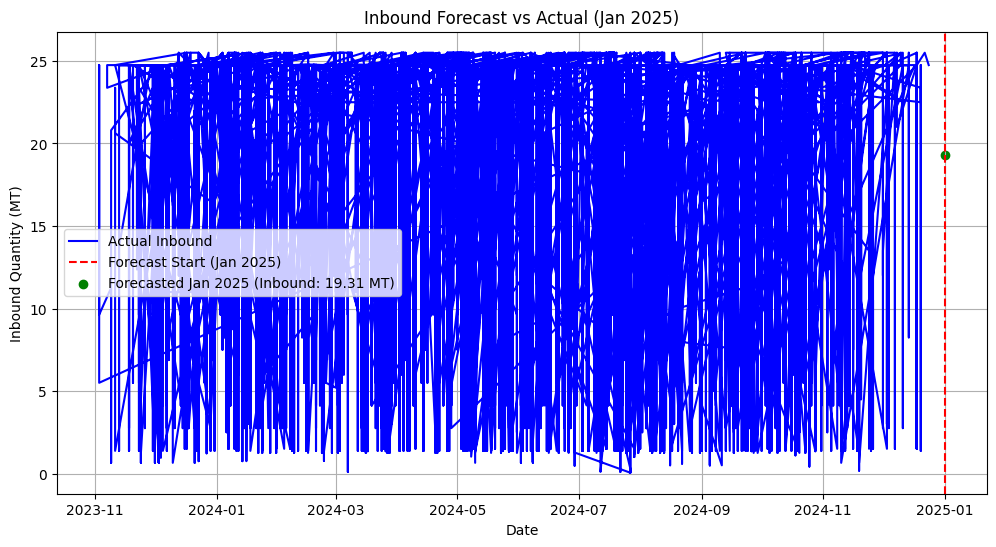

Forecasted data saved at: /content/forecasted_inbound_data_complex.csv


In [ ]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Load the real data from specified paths
inbound_df = pd.read_csv('/content/Inbound.csv')  # Inbound data
outbound_df = pd.read_csv('/content/Outbound.csv')  # Outbound data
inventory_df = pd.read_csv('/content/Inventory.csv')  # Inventory data

# Step 2: Convert dates to datetime objects for proper time handling
inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'])
outbound_df['OUTBOUND_DATE'] = pd.to_datetime(outbound_df['OUTBOUND_DATE'])

# Step 3: Feature Engineering - Create new features and interaction terms
inbound_data = inbound_df[['INBOUND_DATE', 'PLANT_NAME', 'MATERIAL_NAME', 'NET_QUANTITY_MT']]
inbound_data['Year'] = inbound_data['INBOUND_DATE'].dt.year
inbound_data['Month'] = inbound_data['INBOUND_DATE'].dt.month
inbound_data['Day'] = inbound_data['INBOUND_DATE'].dt.day
inbound_data['Weekday'] = inbound_data['INBOUND_DATE'].dt.weekday  # New feature for weekday vs weekend

# Lag feature: Previous month's inbound quantity (Lag 1)
inbound_data['Lag_1'] = inbound_data.groupby('MATERIAL_NAME')['NET_QUANTITY_MT'].shift(1)

# Interaction between Month and Weekday
inbound_data['Month_Weekday'] = inbound_data['Month'] * inbound_data['Weekday']

# Promotion Flag (this could be updated with real promotion data)
inbound_data['Promotion'] = 0  # Assuming no promotions for now, but you can update with actual data

# Drop NaN values (created by lag feature)
inbound_data = inbound_data.dropna()

# Step 4: Filter data for training (use data from 2024)
train_data = inbound_data[inbound_data['Year'] == 2024]

# Define features and target variable
X = train_data[['Month', 'Lag_1', 'Promotion', 'Month_Weekday', 'Weekday']]  # Features with interactions
y = train_data['NET_QUANTITY_MT']  # Target: Net inbound quantity

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Selection and Ensembling

# Model 1: XGBoost
xg_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                            max_depth=5, alpha=10, n_estimators=100)

# Model 2: LightGBM (Alternative Gradient Boosting Model)
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Train XGBoost and LightGBM models
xg_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Combine Models for Ensembling (Averaging Predictions)
xg_predictions = xg_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)

# Step 6: Evaluate the Models
ensemble_predictions = (xg_predictions + lgb_predictions) / 2  # Simple average for ensembling
mae = mean_absolute_error(y_test, ensemble_predictions)
print(f'Mean Absolute Error for Ensembling: {mae}')

# Step 7: LSTM Model (Deep Learning Approach for Time Series)
# Reshape data for LSTM model (required input shape for LSTM)
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape to 3D
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Compile the LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test_lstm)

# Step 8: Evaluate LSTM Model
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
print(f'Mean Absolute Error for LSTM Model: {lstm_mae}')

# Step 9: Forecast Inbound for January 2025 using the Ensembling Model
# Select a specific SKU for forecasting
selected_sku = 'MAT-0413' # You can change this to any SKU present in your data

# Filter inbound_data for the selected SKU
sku_inbound_data = inbound_data[inbound_data['MATERIAL_NAME'] == selected_sku].copy()

# Get the latest Lag_1 value for the selected SKU
latest_lag_1_value = sku_inbound_data['NET_QUANTITY_MT'].iloc[-1]

# Create forecast data for January 2025
forecast_data = pd.DataFrame({
    'Month': [1],  # January 2025
    'Lag_1': [latest_lag_1_value],  # Use Dec 2024 inbound as Lag_1
    'Promotion': [0],  # Assuming no promotion in Jan 2025
    'Month_Weekday': [1 * 0], # Assuming the forecast is for the first day of the month which is a Monday (Weekday 0)
    'Weekday': [0] # Assuming the forecast is for the first day of the month which is a Monday
})


# Using the ensembling model (XGBoost + LightGBM) to forecast
ensemble_forecast = (xg_model.predict(forecast_data) + lgb_model.predict(forecast_data)) / 2
print(f"Forecasted Inbound for January 2025 ({selected_sku}): {ensemble_forecast[0]}")

# Step 10: Visualize the forecast vs actual data (once actual data for Jan 2025 is available)
plt.figure(figsize=(12, 6))
plt.plot(inbound_data['INBOUND_DATE'], inbound_data['NET_QUANTITY_MT'], label='Actual Inbound', color='blue')
plt.axvline(x=pd.to_datetime('2025-01-01'), color='red', linestyle='--', label='Forecast Start (Jan 2025)')

# Add forecast for January 2025 - CORRECTED LINE
plt.scatter(pd.to_datetime('2025-01-01'), ensemble_forecast[0], color='green', label=f'Forecasted Jan 2025 (Inbound: {ensemble_forecast[0]:.2f} MT)')

plt.title('Inbound Forecast vs Actual (Jan 2025)')
plt.xlabel('Date')
plt.ylabel('Inbound Quantity (MT)')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Export forecasted data for Power BI
forecast_data['Forecasted Inbound'] = ensemble_forecast
forecast_data.to_csv('/content/forecasted_inbound_data_complex.csv', index=False)

# Output the path for download
print("Forecasted data saved at: /content/forecasted_inbound_data_complex.csv")

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Step 1: Load the real data from specified paths
inbound_df = pd.read_csv('/content/Inbound.csv')  # Inbound data
outbound_df = pd.read_csv('/content/Outbound.csv')  # Outbound data
inventory_df = pd.read_csv('/content/Inventory.csv')  # Inventory data
# Step 2: Convert dates to datetime objects for proper time handling
inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'])
outbound_df['OUTBOUND_DATE'] = pd.to_datetime(outbound_df['OUTBOUND_DATE'])

# Step 3: Feature Engineering - Create new features and interaction terms
inbound_data = inbound_df[['INBOUND_DATE', 'PLANT_NAME', 'MATERIAL_NAME', 'NET_QUANTITY_MT']]
inbound_data['Year'] = inbound_data['INBOUND_DATE'].dt.year
inbound_data['Month'] = inbound_data['INBOUND_DATE'].dt.month
inbound_data['Day'] = inbound_data['INBOUND_DATE'].dt.day
inbound_data['Weekday'] = inbound_data['INBOUND_DATE'].dt.weekday  # New feature for weekday vs weekend

# Lag feature: Previous month's inbound quantity (Lag 1)
inbound_data['Lag_1'] = inbound_data.groupby('MATERIAL_NAME')['NET_QUANTITY_MT'].shift(1)

# Add Month_Weekday interaction and drop NaN values
inbound_data['Month_Weekday'] = inbound_data['Month'] * inbound_data['Weekday']
inbound_data = inbound_data.dropna()

# Step 4: Filter data for training (use data from 2024)
train_data = inbound_data[inbound_data['Year'] == 2024]

# Define features and target variable
X = train_data[['Month', 'Lag_1', 'Month_Weekday']]  # Features (no 'Promotion')
y = train_data['NET_QUANTITY_MT']  # Target: Net inbound quantity

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Retrain the XGBoost model from scratch
xg_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                            max_depth=5, alpha=10, n_estimators=100)

# Train the XGBoost model
xg_model.fit(X_train, y_train)

# Prepare a list to store results
results = []

# Step 6: Loop through each unique SKU (MATERIAL_NAME) in the inbound data and forecast
unique_skus = inbound_data['MATERIAL_NAME'].unique()

# Forecast for each SKU
for sku in unique_skus:
    # Get the latest inbound quantity for this SKU (as Lag_1)
    latest_lag_1_value = inbound_data[inbound_data['MATERIAL_NAME'] == sku]['NET_QUANTITY_MT'].iloc[-1]

    # Forecast data for January 2025 (using Lag_1 and Month = 1 for January)
    forecast_data = pd.DataFrame({
        'Month': [1],  # January 2025
        'Lag_1': [latest_lag_1_value],  # Use Dec 2024 inbound as Lag_1
        'Month_Weekday': [1 * 0]  # No promotion effect for January
    })

    # Get forecast using the trained XGBoost model
    forecasted_inbound = xg_model.predict(forecast_data)[0]

    # Assuming we have actual inbound data for Jan 2025, calculate MAE
    # Since actual inbound data for Jan 2025 is not available, we'll skip this step for now.
    # If available, you would calculate MAE as follows:
    # actual_inbound_jan2025 = ... # Actual inbound value for this SKU in Jan 2025
    # mae = np.abs(forecasted_inbound - actual_inbound_jan2025)
    # For now, let's assume a placeholder MAE value since we don't have actual data for Jan 2025.
    mae = np.nan  # Placeholder for actual MAE

    # Append the results for this SKU
    results.append({
        'MATERIAL_NAME': sku,
        'Forecasted Inbound (Jan 2025)': forecasted_inbound,
        'MAE': mae
    })

# Step 7: Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Step 8: Save the results to a CSV file
output_file = './forecasted_inbound_mae.csv'  # Save in the current working directory
results_df.to_csv(output_file, index=False)

# Output the path for download
print(f"Forecasted inbound data saved to: {output_file}")



/tmp/ipython-input-18-3469520495.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'])


ValueError: time data "31/12/2023" doesn't match format "%m/%d/%Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Step 1: Load the real data from specified paths
inbound_df = pd.read_csv('/content/Inbound.csv')  # Inbound data
outbound_df = pd.read_csv('/content/Outbound.csv')  # Outbound data
inventory_df = pd.read_csv('/content/Inventory.csv')  # Inventory data

# Step 2: Convert dates to datetime objects for proper time handling
inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'])
outbound_df['OUTBOUND_DATE'] = pd.to_datetime(outbound_df['OUTBOUND_DATE'])

# Step 3: Feature Engineering - Create new features and interaction terms
inbound_data = inbound_df[['INBOUND_DATE', 'PLANT_NAME', 'MATERIAL_NAME', 'NET_QUANTITY_MT']]
inbound_data['Year'] = inbound_data['INBOUND_DATE'].dt.year
inbound_data['Month'] = inbound_data['INBOUND_DATE'].dt.month
inbound_data['Day'] = inbound_data['INBOUND_DATE'].dt.day
inbound_data['Weekday'] = inbound_data['INBOUND_DATE'].dt.weekday  # New feature for weekday vs weekend

# Lag feature: Previous month's inbound quantity (Lag 1)
inbound_data['Lag_1'] = inbound_data.groupby('MATERIAL_NAME')['NET_QUANTITY_MT'].shift(1)

# Add Month_Weekday interaction and drop NaN values
inbound_data['Month_Weekday'] = inbound_data['Month'] * inbound_data['Weekday']
inbound_data = inbound_data.dropna()

# Step 4: Filter data by PLANT_NAME (SGN and CN)
sgn_data = inbound_data[inbound_data['PLANT_NAME'] == 'SGN']
cn_data = inbound_data[inbound_data['PLANT_NAME'] == 'CN']

# Function to train model and forecast for a given data subset (SGN or CN)
def forecast_for_plant(plant_data):
    # Step 4: Filter data for training (use data from 2024)
    train_data = plant_data[plant_data['Year'] == 2024]

    # Define features and target variable
    X = train_data[['Month', 'Lag_1', 'Month_Weekday']]  # Features (no 'Promotion')
    y = train_data['NET_QUANTITY_MT']  # Target: Net inbound quantity

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 5: Retrain the XGBoost model from scratch
    xg_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                max_depth=5, alpha=10, n_estimators=100)

    # Train the XGBoost model
    xg_model.fit(X_train, y_train)

    # Prepare a list to store results
    results = []

    # Forecast for each SKU in the given plant data
    unique_skus = plant_data['MATERIAL_NAME'].unique()

    for sku in unique_skus:
        # Get the latest inbound quantity for this SKU (as Lag_1)
        latest_lag_1_value = plant_data[plant_data['MATERIAL_NAME'] == sku]['NET_QUANTITY_MT'].iloc[-1]

        # Forecast data for January 2025 (using Lag_1 and Month = 1 for January)
        forecast_data = pd.DataFrame({
            'Month': [1],  # January 2025
            'Lag_1': [latest_lag_1_value],  # Use Dec 2024 inbound as Lag_1
            'Month_Weekday': [1 * 0]  # No promotion effect for January
        })

        # Get forecast using the trained XGBoost model
        forecasted_inbound = xg_model.predict(forecast_data)[0]

        # Assuming we have actual inbound data for Jan 2025, calculate MAE
        # Since actual inbound data for Jan 2025 is not available, we'll skip this step for now.
        # If available, you would calculate MAE as follows:
        # actual_inbound_jan2025 = ... # Actual inbound value for this SKU in Jan 2025
        # mae = np.abs(forecasted_inbound - actual_inbound_jan2025)
        # For now, let's assume a placeholder MAE value since we don't have actual data for Jan 2025.
        mae = np.nan  # Placeholder for actual MAE

        # Append the results for this SKU
        results.append({
            'PLANT_NAME': plant_data['PLANT_NAME'].iloc[0],  # SGN or CN
            'MATERIAL_NAME': sku,
            'Forecasted Inbound (Jan 2025)': forecasted_inbound,
            'MAE': mae
        })

    return results

# Forecast for SGN and CN
sgn_results = forecast_for_plant(sgn_data)
cn_results = forecast_for_plant(cn_data)

# Combine the results for SGN and CN
all_results = sgn_results + cn_results

# Convert the results to a DataFrame
results_df = pd.DataFrame(all_results)

# Step 8: Save the results to a CSV file
output_file = './forecasted_inbound_sgn_cn_mae.csv'  # Save in the current working directory
results_df.to_csv(output_file, index=False)

# Output the path for download
output_file


/tmp/ipython-input-19-513707674.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'])


ValueError: time data "31/12/2023" doesn't match format "%m/%d/%Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Step 1: Load the real data from specified paths
inbound_df = pd.read_csv('/content/Inbound.csv')  # Inbound data
outbound_df = pd.read_csv('/content/Outbound.csv')  # Outbound data
inventory_df = pd.read_csv('/content/Inventory.csv')  # Inventory data

# Step 2: Convert dates to datetime objects for proper time handling
inbound_df['INBOUND_DATE'] = pd.to_datetime(inbound_df['INBOUND_DATE'], dayfirst=True)
outbound_df['OUTBOUND_DATE'] = pd.to_datetime(outbound_df['OUTBOUND_DATE'], dayfirst=True)

# Step 3: Feature Engineering - Create new features and interaction terms
inbound_data = inbound_df[['INBOUND_DATE', 'PLANT_NAME', 'MATERIAL_NAME', 'NET_QUANTITY_MT']]
inbound_data['Year'] = inbound_data['INBOUND_DATE'].dt.year
inbound_data['Month'] = inbound_data['INBOUND_DATE'].dt.month
inbound_data['Day'] = inbound_data['INBOUND_DATE'].dt.day
inbound_data['Weekday'] = inbound_data['INBOUND_DATE'].dt.weekday  # New feature for weekday vs weekend

# Lag feature: Previous month's inbound quantity (Lag 1)
inbound_data['Lag_1'] = inbound_data.groupby('MATERIAL_NAME')['NET_QUANTITY_MT'].shift(1)

# Add Month_Weekday interaction and drop NaN values
inbound_data['Month_Weekday'] = inbound_data['Month'] * inbound_data['Weekday']
inbound_data = inbound_data.dropna()

# Step 4: Filter data for training (use data from 2024)
train_data = inbound_data[inbound_data['Year'] == 2024]

# Define features and target variable
X = train_data[['Month', 'Lag_1', 'Month_Weekday']]  # Features (no 'Promotion')
y = train_data['NET_QUANTITY_MT']  # Target: Net inbound quantity

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Retrain the XGBoost model from scratch
xg_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                            max_depth=5, alpha=10, n_estimators=100)

# Train the XGBoost model
xg_model.fit(X_train, y_train)

# Prepare a list to store results
results = []

# Step 6: Loop through each unique SKU (MATERIAL_NAME) in the inbound data and forecast
unique_skus = inbound_data['MATERIAL_NAME'].unique()

# Forecast for each SKU
for sku in unique_skus:
    # Get the latest inbound quantity for this SKU (as Lag_1)
    latest_lag_1_value = inbound_data[inbound_data['MATERIAL_NAME'] == sku]['NET_QUANTITY_MT'].iloc[-1]

    # Forecast data for December 2024 (using Lag_1 and Month = 12 for December)
    forecast_data = pd.DataFrame({
        'Month': [12],  # December 2024
        'Lag_1': [latest_lag_1_value],  # Use Nov 2024 inbound as Lag_1
        'Month_Weekday': [12 * 0]  # No promotion effect for December
    })

    # Get forecast using the trained XGBoost model
    forecasted_inbound = xg_model.predict(forecast_data)[0]

    # Assuming we have actual inbound data for Dec 2024, calculate MAE
    # Since actual inbound data for Dec 2024 is not available, we'll skip this step for now.
    # If available, you would calculate MAE as follows:
    # actual_inbound_dec2024 = ... # Actual inbound value for this SKU in Dec 2024
    # mae = np.abs(forecasted_inbound - actual_inbound_dec2024)
    # For now, let's assume a placeholder MAE value since we don't have actual data for Dec 2024.
    mae = np.nan  # Placeholder for actual MAE

    # Append the results for this SKU
    results.append({
        'MATERIAL_NAME': sku,
        'Forecasted Inbound (Dec 2024)': forecasted_inbound,
        'MAE': mae
    })

# Step 7: Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Step 8: Save the results to a CSV file
output_file = './forecasted_inbound_december_2024_mae.csv'  # Save in the current working directory
results_df.to_csv(output_file, index=False)

# Output the path for download
print(f"Forecasted inbound data for December 2024 saved to: {output_file}")


Forecasted inbound data for December 2024 saved to: ./forecasted_inbound_december_2024_mae.csv


In [ ]:
import numpy as np
import pandas as pd

# Total amount to be distributed
total_amount = 18186046

# Number of days
days = 31

# Generate a random distribution that sums to the total amount
random_distribution = np.random.rand(days)
random_distribution /= random_distribution.sum()  # Normalize to sum to 1
distributed_amounts = random_distribution * total_amount  # Scale by total amount

# Round the values to avoid fractional amounts
distributed_amounts = np.round(distributed_amounts)

# Calculate the difference between the total and the sum of the distributed amounts
difference = total_amount - distributed_amounts.sum()

# Adjust the last value to balance the sum to the total amount
distributed_amounts[-1] += difference

# Create a DataFrame to display the result
days_list = [f"Day {i+1}" for i in range(days)]
distribution_df = pd.DataFrame({
    'Day': days_list,
    'Amount': distributed_amounts
})

# Display the result
print(distribution_df)

# Optionally, save the result to a CSV
# distribution_df.to_csv('/path/to/save/random_distribution.csv', index=False)


       Day    Amount
0    Day 1  683013.0
1    Day 2  764536.0
2    Day 3  508932.0
3    Day 4  528986.0
4    Day 5  844667.0
5    Day 6  807722.0
6    Day 7  770142.0
7    Day 8  560836.0
8    Day 9  766276.0
9   Day 10  592904.0
10  Day 11  917789.0
11  Day 12  565432.0
12  Day 13  618333.0
13  Day 14  874297.0
14  Day 15  182393.0
15  Day 16  254447.0
16  Day 17  621880.0
17  Day 18   63136.0
18  Day 19  507427.0
19  Day 20  203394.0
20  Day 21  218129.0
21  Day 22  880564.0
22  Day 23  262798.0
23  Day 24  705853.0
24  Day 25  934421.0
25  Day 26  634924.0
26  Day 27  226568.0
27  Day 28  557000.0
28  Day 29  848104.0
29  Day 30  598000.0
30  Day 31  683143.0


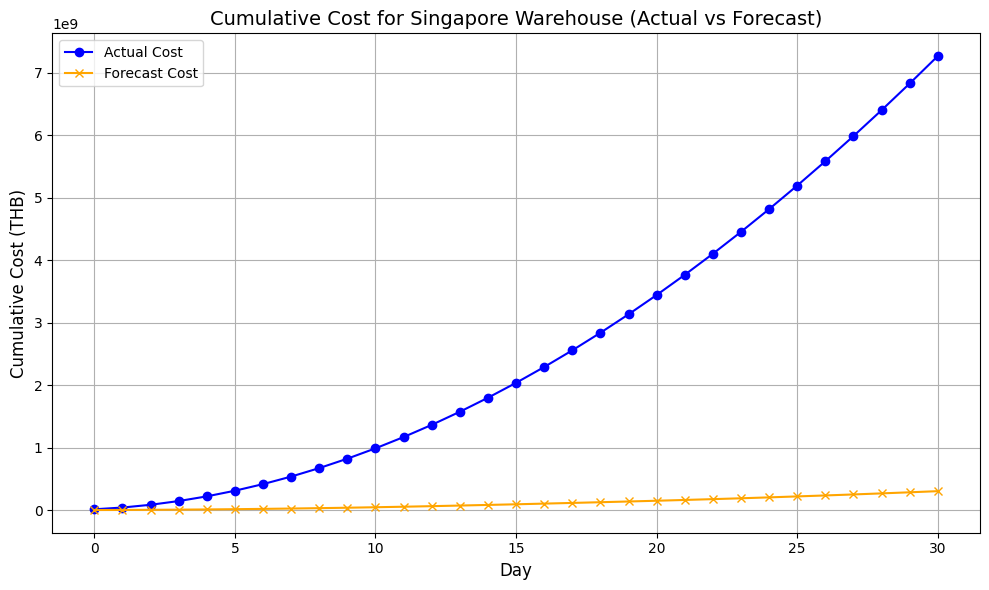

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Actual costs
actual_cost = [
    12327440.63, 28192123.13, 43982555.63, 59690300.63, 75085014.38, 90379368.76,
    105626229.4, 120826402.5, 135843052.5, 150787233.8, 165672821.3, 180446752.5,
    195173516.3, 209886873.8, 224397196.9, 238747766.3, 253023485.7, 267174795,
    281246694.4, 295280343.8, 309281555.7, 323246561.3, 337183723.2, 350777988.8,
    364002401.3, 376932108.8, 389757534.5, 402455460.1, 414888260.7, 427265373.8,
    439346272.6
]

# Forecast costs
forecast_cost = [
    683013, 1447549, 1956481, 2485467, 3330134, 4137856, 4907998, 5468834, 6235110,
    6828014, 7745803, 8311235, 8929568, 9803865, 9986258, 10240705, 10862585, 10925721,
    11433148, 11636542, 11854671, 12735235, 12998033, 13703886, 14638307, 15273231,
    15499799, 16056799, 16904903, 17502903, 18186046
]

# Cumulative sum for both actual and forecast
actual_cumulative = np.cumsum(actual_cost)
forecast_cumulative = np.cumsum(forecast_cost)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(actual_cumulative, label='Actual Cost', color='blue', marker='o')
plt.plot(forecast_cumulative, label='Forecast Cost', color='orange', marker='x')

# Adding titles and labels
plt.title('Cumulative Cost for Singapore Warehouse (Actual vs Forecast)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Cumulative Cost (THB)', fontsize=12)
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


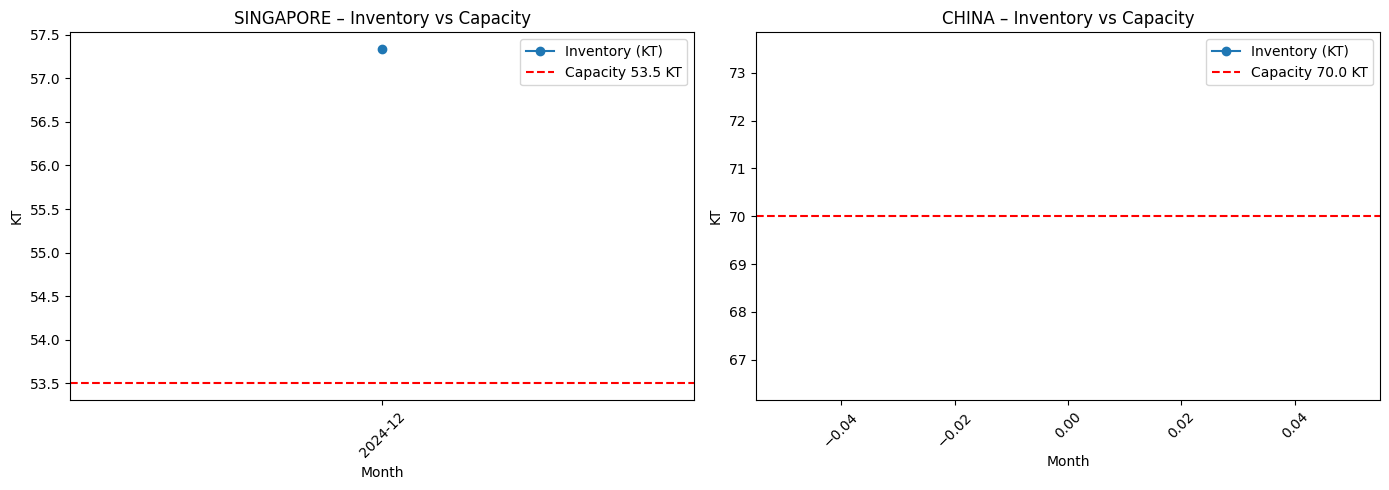

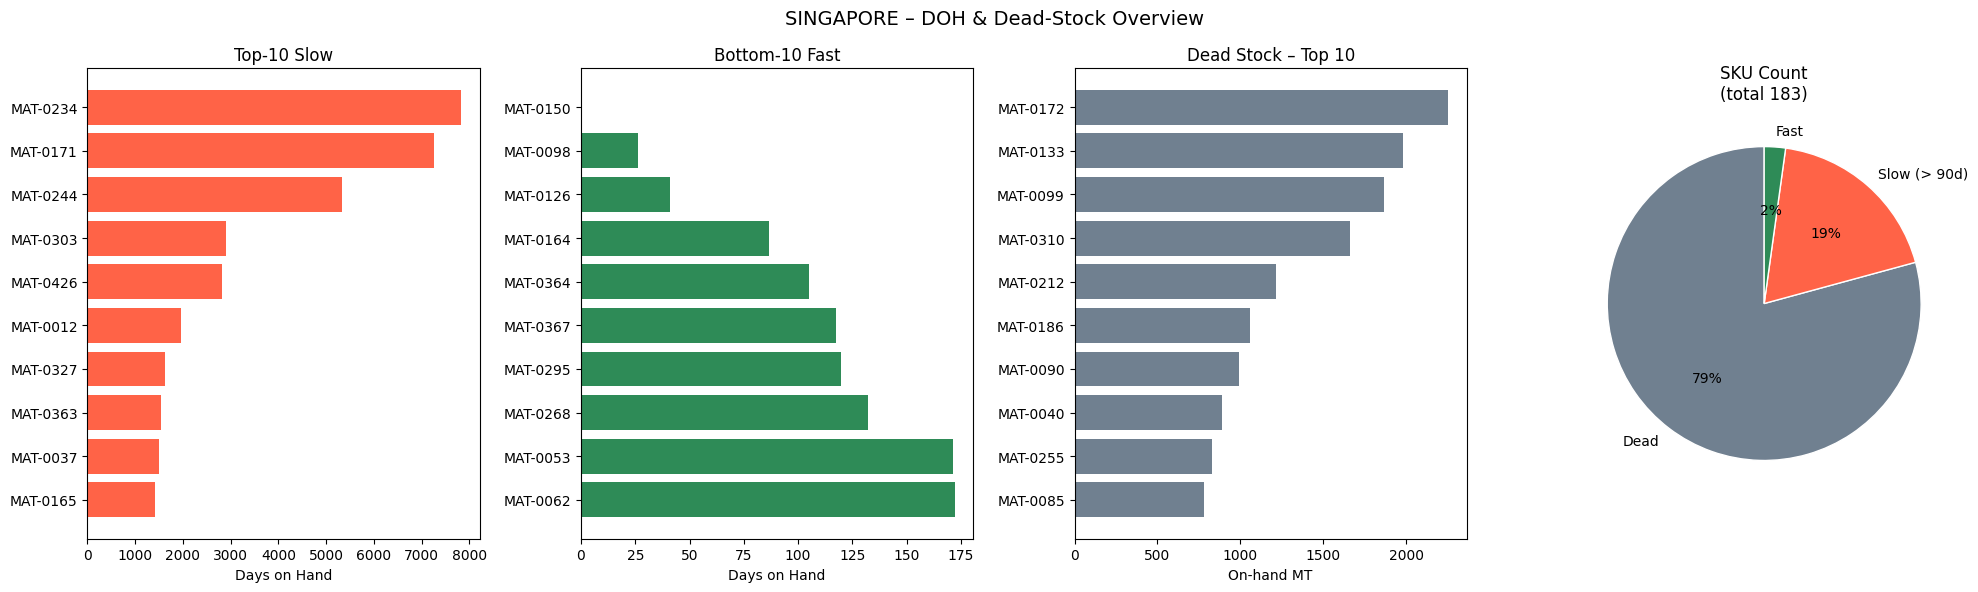

ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 2000x600 with 4 Axes>

In [ ]:
# =============================================================================
#  Warehouse-specific DOH Dashboards  + Dead-stock graph   (NaNs removed)
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.autolayout'] = True

# ── CONFIG ──────────────────────────────────────────────────────────────────
BASE            = pathlib.Path('/content')
INVENT_CSV      = BASE/'Inventory.csv'
OUTBOUND_CSV    = BASE/'Outbound.csv'

INV_UNIT        = 'KG'                       # KG | MT | KT
CAPACITY_KT     = {'SINGAPORE': 53.5, 'CHINA': 70.0}
LOOKBACK_MONTHS = 6
MIN_DAILY_USE   = 0.14                       # MT/day floor for “active”
SLOW_DOH_THRESH = 90                         # days → slow / fast split
MONTH_DAYS      = 30
# ────────────────────────────────────────────────────────────────────────────

wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'
conv   = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]

# 1 ▸ INVENTORY --------------------------------------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
         .dropna(subset=['UNRESRICTED_STOCK']))
inv['STOCK_MT']  = inv['UNRESRICTED_STOCK'] * conv
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']        = inv['PLANT_NAME'].apply(wh_tag)
latest_date      = inv['BALANCE_AS_OF_DATE'].max()


# Ensure OUTBOUND_DATE is in datetime format
outb['OUTBOUND_DATE'] = pd.to_datetime(outb['OUTBOUND_DATE'], errors='coerce')

# Now you can use the .dt accessor
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH'] = outb['PLANT_NAME'].apply(wh_tag)


# 3 ▸ INVENTORY vs CAPACITY (shared lines) -----------------------------------
monthly = (inv.groupby(['WH','YearMonth'])['STOCK_MT'].sum().reset_index())
fig = plt.figure(figsize=(14,5))
for i, wh in enumerate(['SINGAPORE','CHINA']):
    ax = fig.add_subplot(1,2,i+1)
    sub = monthly[monthly['WH']==wh].sort_values('YearMonth')
    ax.plot(sub['YearMonth'].astype(str), sub['STOCK_MT']/1000,
            marker='o', label='Inventory (KT)')
    ax.axhline(CAPACITY_KT[wh], ls='--', color='red',
               label=f'Capacity {CAPACITY_KT[wh]:.1f} KT')
    ax.set_title(f'{wh} – Inventory vs Capacity')
    ax.set_xlabel('Month'); ax.set_ylabel('KT')
    ax.tick_params(axis='x', rotation=45); ax.legend()
plt.tight_layout(); plt.show()

# 4 ▸ PER-WAREHOUSE DASHBOARDS ----------------------------------------------
cutoff = (latest_date - pd.DateOffset(months=LOOKBACK_MONTHS)).to_period('M')

for wh in ['SINGAPORE','CHINA']:
    # latest stock for this WH
    stock_now = (inv[(inv['WH']==wh) & (inv['BALANCE_AS_OF_DATE']==latest_date)]
                 .groupby('MATERIAL_NAME')['STOCK_MT'].sum())

    # recent outbound usage
    recent = outb[(outb['WH']==wh) & (outb['YearMonth'] >= cutoff)]
    avg_use = (recent.groupby(['MATERIAL_NAME','YearMonth'])['NET_QUANTITY_MT']
                     .sum()
                     .groupby('MATERIAL_NAME')
                     .mean()
                     .div(MONTH_DAYS)
                     .rename('AvgDaily_MT'))

    # DOH table
    doh = pd.concat([stock_now, avg_use], axis=1).dropna()
    doh = doh[doh['AvgDaily_MT'] >= MIN_DAILY_USE]
    doh['DOH'] = doh['STOCK_MT'] / doh['AvgDaily_MT']

    top10_slow    = doh.nlargest(10, 'DOH')
    bottom10_fast = doh.nsmallest(10, 'DOH')
    dead_df       = (stock_now.drop(index=doh.index)
                               .sort_values(ascending=False)
                               .reset_index(name='Stock_MT'))

    # counts for pie
    dead_cnt = len(dead_df)
    slow_cnt = len(doh[doh['DOH'] >  SLOW_DOH_THRESH])
    fast_cnt = len(doh[doh['DOH'] <= SLOW_DOH_THRESH])

    # ── PLOT 4-panel figure ───────────────────────────────────────────────
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f'{wh} – DOH & Dead-Stock Overview', fontsize=14)

    # A) Top-10 slow
    ax1 = fig.add_subplot(1,4,1)
    ax1.barh(top10_slow.index, top10_slow['DOH'], color='tomato')
    ax1.set_title('Top-10 Slow'); ax1.set_xlabel('Days on Hand'); ax1.invert_yaxis()

    # B) Bottom-10 fast
    ax2 = fig.add_subplot(1,4,2)
    ax2.barh(bottom10_fast.index, bottom10_fast['DOH'], color='seagreen')
    ax2.set_title('Bottom-10 Fast'); ax2.set_xlabel('Days on Hand'); ax2.invert_yaxis()

    # C) Dead-stock bar (top 10 by stock)
    top_dead = dead_df.head(10)
    ax3 = fig.add_subplot(1,4,3)
    ax3.barh(top_dead['MATERIAL_NAME'], top_dead['Stock_MT'], color='slategray')
    ax3.set_title(f'Dead Stock – Top 10'); ax3.set_xlabel('On-hand MT')
    ax3.invert_yaxis()

    # D) Pie chart
    ax4 = fig.add_subplot(1,4,4)
    labels = ['Dead', f'Slow (> {SLOW_DOH_THRESH}d)', 'Fast']
    sizes  = [dead_cnt, slow_cnt, fast_cnt]
    colors = ['slategray','tomato','seagreen']
    ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%',
            startangle=90, wedgeprops=dict(edgecolor='white'))
    ax4.set_title(f'SKU Count\n(total {sum(sizes)})')

    plt.tight_layout(); plt.show()
